# **Similarity between two images**

## **Import**

In [109]:
!pip install keras
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install sklearn

In [110]:
# Import libraries and modules
from keras.datasets import cifar100
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Resizing
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

## **Dataset**

### Utility functions

In [111]:
def normalize_pixels(image):
    """normalize pixels to be between 0 and 1"""

	# convert from integers to floats
    image_norm = image.astype('float32')
	# normalize to range 0-1
    image_norm = image_norm / 255.0
	# return normalized images
    return image_norm

def de_normalise_pixels(image):
    """de-normalize pixels to be between 0 and 255"""

    image_de_norm = image * 255.0
    return image_de_norm

def load_image(path):
    """load image from path and convert to array"""

    img = load_img(path, target_size=(160, 160), interpolation='bilinear')
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = normalize_pixels(x)
    return x

def unison_shuffled_copies(a, b):
    """shuffle two arrays in unison"""

    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Load Dataset

In [112]:
# Variables

DATA_PATH = './data/dataset'
DATA_TRAIN_SPLIT = 0.8
DATA_VALIDATION_SPLIT = 0.1
# The TEST split will be the remaining of the two splits

#amount_of_positive_pairs_per_class = 50

In [113]:
# Load images into arrays
import pathlib

data_dir = pathlib.Path(DATA_PATH)

image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
print("Total amount of images: " + str(image_count))

folders = [x for x in data_dir.iterdir() if x.is_dir()]

img_array_data = []

for i, folder in enumerate(folders):
    img_array_data.append([])

    for j, img in enumerate(folder.iterdir()):
        img_array_data[i].append(load_image(img))

Total amount of images: 555


### Create image pairs

In [114]:
data = []
labels = []

# Create image pairs
def create_image_pairs(images):
    for i, array in enumerate(images):
        for j in range(len(array)):
            data.append([
                images[i][j], 
                images[i][np.random.randint(0, len(images[i]) - 1)]])
            labels.append(1)

            x_1 = np.random.randint(0, len(images) - 1)
            x_2 = np.random.randint(0, len(images[x_1]) - 1)

            data.append([
                images[i][j], 
                images[x_1][x_2]])
            labels.append(0)

create_image_pairs(img_array_data)

data = np.array(data)
labels = np.array(labels)

In [115]:
# Shuffle Dataset
data, labels = unison_shuffled_copies(data, labels)

show_amount = 10
print(data[:show_amount])
print(labels[:show_amount])

[[[[[[0.02745098 0.01568628 0.01960784]
     [0.02745098 0.01960784 0.01960784]
     [0.02745098 0.01568628 0.02352941]
     ...
     [0.01960784 0.00784314 0.01176471]
     [0.01960784 0.00784314 0.01568628]
     [0.01568628 0.01176471 0.01176471]]

    [[0.02745098 0.01568628 0.01568628]
     [0.03529412 0.01960784 0.01568628]
     [0.02352941 0.01960784 0.01568628]
     ...
     [0.01960784 0.00784314 0.00784314]
     [0.01568628 0.00784314 0.00784314]
     [0.01960784 0.00784314 0.01568628]]

    [[0.02352941 0.01568628 0.01960784]
     [0.02745098 0.01960784 0.02352941]
     [0.02352941 0.01960784 0.01568628]
     ...
     [0.01568628 0.00784314 0.00784314]
     [0.01568628 0.00784314 0.01176471]
     [0.01960784 0.00784314 0.01176471]]

    ...

    [[0.45490196 0.42352942 0.36862746]
     [0.4627451  0.42745098 0.3529412 ]
     [0.44705883 0.42352942 0.3372549 ]
     ...
     [0.01568628 0.01176471 0.01176471]
     [0.01960784 0.01176471 0.01176471]
     [0.01568628 0.01176471 0

In [118]:
# Split data into train, validation, and test

train_split = int(DATA_TRAIN_SPLIT * len(data))
validation_split = train_split+int(DATA_VALIDATION_SPLIT * len(data))

print("TRAIN SPLIT: " + "0 - " + str(train_split) + " | " + str(train_split) + " | " + str(DATA_TRAIN_SPLIT*100) + '%')
print("VALIDATION SPLIT: " + str(train_split) + " - " + str(validation_split) + " | " + str(validation_split-train_split) + " | " + str(DATA_VALIDATION_SPLIT*100) + '%')
print("TEST SPLIT: " + str(validation_split) + " - " + str(len(data)) + " | " + str(len(data) - validation_split) + " | " + str(100 - DATA_TRAIN_SPLIT*100 - DATA_VALIDATION_SPLIT*100) + '%')

data_train = data[0:train_split]
data_validation = data[train_split:validation_split]
data_test = data[validation_split:]

labels_train = labels[0:train_split]
labels_validation = labels[train_split:validation_split]
labels_test = labels[validation_split:]

print("---")
print("Training Data Shape: " + str(data_train.shape))
print("Validation Data Shape: " + str(data_validation.shape))
print("Test Data Shape: " + str(data_test.shape))
print("---")
print("Training Labels Shape: " + str(labels_train.shape))
print("Validation Labels Shape: " + str(labels_validation.shape))
print("Test Labels Shape: " + str(labels_test.shape))

TRAIN SPLIT: 0 - 888 | 888 | 80.0%
VALIDATION SPLIT: 888 - 999 | 111 | 10.0%
TEST SPLIT: 999 - 1110 | 111 | 10.0%
---
Training Data Shape: (888, 2, 1, 160, 160, 3)
Validation Data Shape: (111, 2, 1, 160, 160, 3)
Test Data Shape: (111, 2, 1, 160, 160, 3)
---
Training Labels Shape: (888,)
Validation Labels Shape: (111,)
Test Labels Shape: (111,)


## **Model**

### Define and Train Model

In [119]:
from keras.regularizers import l2

class SiameseNetwork:
    """Class that constructs the Siamese Net for training."""

    def __init__(self, learning_rate, decay_rate, input_shape = (160, 160, 3)):
        """Inits SiameseNetwork with the provided values for the attributes."""

        self.input_shape = input_shape  # Size of images
        self.model = []
        self.history = None
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self._construct_siamese_architecture()

    def _construct_siamese_architecture(self):
        """ Constructs the siamese architecture and stores it in the class"""

        # Let's define the cnn architecture

        convolutional_net = Sequential()

        base_model = MobileNetV2(input_shape=(self.input_shape), include_top = False, weights='imagenet')
        base_model.trainable = False
        convolutional_net.add(base_model)
        
        convolutional_net.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', name='conv_1'))
        # convolutional_net.add(MaxPooling2D())

        # convolutional_net.add(Conv2D(filters=64, kernel_size=(1, 1), activation='relu', name='Conv2'))
        # convolutional_net.add(MaxPooling2D())

        # convolutional_net.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', name='Conv4'))

        convolutional_net.add(GlobalAveragePooling2D())
        convolutional_net.add(Dropout(0.25))
        convolutional_net.add(Dense(units=1024, activation='sigmoid', name='dense_1'))

        convolutional_net.summary()

        # Now the pairs of images
        input_image_1 = Input(self.input_shape)
        input_image_2 = Input(self.input_shape)

        encoded_image_1 = convolutional_net(input_image_1)
        encoded_image_2 = convolutional_net(input_image_2)

        # L1 distance layer between the two encoded outputs
        # One could use Subtract from Keras, but we want the absolute value
        l1_distance_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
        l1_distance = l1_distance_layer([encoded_image_1, encoded_image_2])

        # Same class or not prediction
        prediction = Dense(units=1, activation='sigmoid', name='prediction')(l1_distance)
        self.model = Model(inputs=[input_image_1, input_image_2], outputs=prediction)

        # Define the optimizer and compile the model
        opt = Adam(learning_rate=self.learning_rate, decay=self.decay_rate)

        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

    def train(self, data_train, labels_train, data_validation, labels_validation, epochs, batch_size, save_model_path):
        """Trains the siamese network

        Args:
            data_train: training data
            labels_train: training labels
            data_validation: validation data
            labels_validation: validation labels
            epochs: number of epochs to train
            batch_size: batch size for training
            save_model_path: path to save the model
        """

        # Train the model
        self.history = self.model.fit([data_train[:, 0, 0], data_train[:, 1, 0]], labels_train,
            validation_data=([data_validation[:, 0, 0], data_validation[:, 1, 0]], labels_validation),
            epochs=epochs, batch_size=batch_size)

        # Save the model
        self.model.save(save_model_path)

siamese_network = SiameseNetwork(learning_rate = 0.0003, decay_rate = 1e-6)
siamese_network.model.summary()
siamese_network.train(data_train, labels_train, data_validation, labels_validation, epochs = 8, batch_size = 32, save_model_path = './models/siamese_model.h5')


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 conv_1 (Conv2D)             (None, 3, 3, 256)         2949376   
                                                                 
 global_average_pooling2d_12  (None, 256)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 5,470,528
Trainable params: 3,212,544
N

In [120]:
# Test

test_image_1 = load_image(r'./data/dataset/all_souls/all_souls_000002.jpg')
test_image_2 = load_image(r'./data/dataset/all_souls/all_souls_000209.jpg')
test_image_3 = load_image(r'./test_image_3.png')

predictions = siamese_network.model.predict([test_image_1, test_image_2])

print(predictions)

[[0.42184845]]


### Export as tensorflow.js model

In [ ]:
shard_size_in_mb = 1024*1024*1024
print(shard_size_in_mb)

1073741824


In [123]:
!tensorflowjs_converter \
    --input_format=keras \
    --weight_shard_size_bytes 1073741824 \
    ./models/siamese_model.h5 \
    ./models/tfjs

### Evaluate Model

In [121]:
_, acc = siamese_network.model.evaluate([data_test[:, 0, 0], data_test[:, 1, 0]], labels_test)
print('%.3f' % (acc))

4/4 [==============================] - 1s 93ms/step - loss: 0.6367 - acc: 0.7568
0.757


## **Test**

### Plot diagnostic learning curves

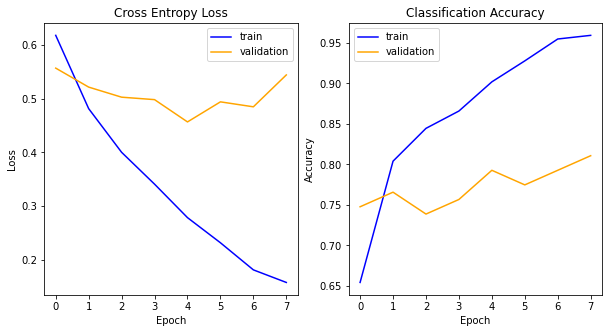

In [122]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['acc'], color='blue', label='train')
	ax[1].plot(history.history['val_acc'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(siamese_network.history)

### Data outside of the dataset

### Kappa Score

In [ ]:
def calculate_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

pred = siamese_network_model.predict(x_test)
pred = np.argmax(pred, axis=1)

kappa = calculate_kappa(old_y_test, pred)
print("Kappa: ", kappa)

### Confusion Matrix

In [ ]:
# sns confusion matrix

cm = confusion_matrix(old_y_test, pred)

cm = cm / cm.astype(float).sum(axis=1) # This line normalizes the calculated confusion matrix

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Convert to tflite**

In [ ]:
model=tf.keras.models.load_model('./model/similarity_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)